In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

Using TensorFlow backend.


In [2]:
train = pd.read_json('kaggle_lceberg_data/train.json')

In [9]:
print train.shape

(1604, 5)


In [5]:
import os
sub_path = "./statoil-iceberg-submissions"
all_files = os.listdir(sub_path)

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1
0,5941774d,0.002585,0.008077
1,4023181e,0.996710,0.995653
2,b20200e4,0.002125,0.001926
3,e7f018bb,0.999916,0.999981
4,4371c8c3,0.994338,0.967255


In [7]:
def get_images(df):
    '''Create 3-channel 'images'. Return rescale-normalised images.'''
    images = []
    for i, row in df.iterrows():
        # Formulate the bands as 75x75 arrays
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        # Rescale
        r = (band_1 - band_1.min()) / (band_1.max() - band_1.min())
        g = (band_2 - band_2.min()) / (band_2.max() - band_2.min())
        b = (band_3 - band_3.min()) / (band_3.max() - band_3.min())

        rgb = np.dstack((r, g, b))
        images.append(rgb)
    return np.array(images)

In [8]:
X = get_images(train)

In [9]:
# print X[0].shape
# print X[0]

(75, 75, 3)
[[[ 0.27193414  0.46787277  0.74459132]
  [ 0.29099295  0.38810471  0.66544634]
  [ 0.25113701  0.33815411  0.66882434]
  ..., 
  [ 0.33259165  0.40291476  0.63570864]
  [ 0.30850655  0.38800466  0.64877246]
  [ 0.20275585  0.4559048   0.80518155]]

 [[ 0.25113924  0.33815686  0.66882412]
  [ 0.27193308  0.25453898  0.60070147]
  [ 0.28166051  0.3193956   0.62967799]
  ..., 
  [ 0.30850766  0.22914994  0.55726323]
  [ 0.25105945  0.43061582  0.73546798]
  [ 0.17414523  0.49013911  0.86700212]]

 [[ 0.25113924  0.25454052  0.61807252]
  [ 0.29099295  0.13668823  0.52803727]
  [ 0.32491869  0.3193956   0.5913252 ]
  ..., 
  [ 0.29091542  0.31929825  0.62141423]
  [ 0.27185434  0.29924369  0.62620289]
  [ 0.14143428  0.38800325  0.80717871]]

 ..., 
 [[ 0.23997096  0.44361773  0.75702796]
  [ 0.25112259  0.44361632  0.74582325]
  [ 0.20281904  0.37236864  0.7371266 ]
  ..., 
  [ 0.21580931  0.53027779  0.86255792]
  [ 0.32482668  0.45588787  0.6808926 ]
  [ 0.308491    0.41707

In [10]:
y = to_categorical(train.is_iceberg.values,num_classes=2)

In [11]:
Xtr, Xv, ytr, yv = train_test_split(X, y, shuffle=False, test_size=0.20)

In [12]:
def ConvBlock(model, layers, filters):
    '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [13]:
def create_model():
    '''Create the FCN and return a keras model.'''

    model = Sequential()

    # Input image: 75x75x3
    model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
    ConvBlock(model, 1, 32)
    # 37x37x32
    ConvBlock(model, 1, 64)
    # 18x18x64
    ConvBlock(model, 1, 128)
    # 9x9x128
    ConvBlock(model, 1, 128)
    # 4x4x128
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    # 4x4x2
    model.add(Activation('softmax'))
    
    return model

In [14]:
# Create the model and compile
model = create_model()
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 75, 75, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
__________

In [16]:
init_epo = 0
num_epo = 30
end_epo = init_epo + num_epo

In [17]:
print ('lr = {}'.format(K.get_value(model.optimizer.lr)))
history = model.fit(Xtr, ytr, 
                    validation_data=(Xv, yv), 
                    batch_size=32, 
                    epochs=end_epo, 
                    initial_epoch=init_epo)
init_epo += num_epo
end_epo = init_epo + num_epo

lr = 9.99999974738e-05
Train on 1283 samples, validate on 321 samples
Epoch 1/30
1283/1283 [==============================] - 19s 15ms/step - loss: 0.5370 - acc: 0.7233 - val_loss: 0.6448 - val_acc: 0.6573
Epoch 2/30
1283/1283 [==============================] - 18s 14ms/step - loss: 0.4347 - acc: 0.7646 - val_loss: 0.6439 - val_acc: 0.6573
Epoch 3/30
1283/1283 [==============================] - 18s 14ms/step - loss: 0.3994 - acc: 0.7911 - val_loss: 0.7234 - val_acc: 0.6573
Epoch 4/30
1283/1283 [==============================] - 17s 13ms/step - loss: 0.3545 - acc: 0.8340 - val_loss: 0.8443 - val_acc: 0.6573
Epoch 5/30
1283/1283 [==============================] - 17s 14ms/step - loss: 0.3091 - acc: 0.8574 - val_loss: 0.8712 - val_acc: 0.6573
Epoch 6/30
1283/1283 [==============================] - 18s 14ms/step - loss: 0.2759 - acc: 0.8792 - val_loss: 0.9977 - val_acc: 0.6573
Epoch 7/30
1283/1283 [==============================] - 17s 13ms/step - loss: 0.2527 - acc: 0.8956 - val_loss: 1.2

In [18]:
l = model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [19]:
def get_cm(inp, label):
    '''Convert the 4x4 layer data to a 75x75 image.'''
    conv = np.rollaxis(conv_fn([inp,0])[0][0],2,0)[label]
    return scipy.misc.imresize(conv, (75,75), interp='nearest')

In [20]:
def info_img (im_idx):
    '''Generate heat maps for the boat (boatness) and iceberg (bergness) for image im_idx.'''
    if (yv[im_idx][1] == 1.0):
        img_type = 'iceberg'
    else:
        img_type = 'boat'
    inp = np.expand_dims(Xv[im_idx], 0)
    img_guess = np.round(model.predict(inp)[0],2)
    if (img_guess[1] > 0.5):
        guess_type = 'iceberg'
    else:
        guess_type = 'boat'
    cm0 = get_cm(inp, 0)
    cm1 = get_cm(inp, 1)
    print ('truth: {}'.format(img_type))
    print ('guess: {}, prob: {}'.format(guess_type, img_guess))
    plt.figure(1,figsize=(10,10))
    plt.subplot(121)
    plt.title('Boatness')
    plt.imshow(Xv[im_idx])
    plt.imshow(cm0, cmap="cool", alpha=0.5)
    plt.subplot(122)
    plt.title('Bergness')
    plt.imshow(Xv[im_idx])
    plt.imshow(cm1, cmap="cool", alpha=0.5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


truth: iceberg
guess: iceberg, prob: [ 0.  1.]


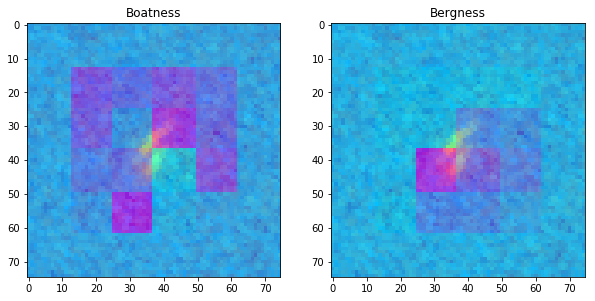

In [26]:
info_img(16)

In [27]:
test = pd.read_json('kaggle_lceberg_data/test.json')
Xtest = get_images(test)
test_predictions = model.predict_proba(Xtest)
submission = pd.DataFrame({'id': test['id'], 'is_iceberg': test_predictions[:, 1]})
submission.to_csv('sub_fcn.csv', index=False)

In [28]:
submission.head(5)

,id,is_iceberg
0,5941774d,0.007682
1,4023181e,0.626564
2,b20200e4,0.002197
3,e7f018bb,0.998817
4,4371c8c3,0.072597
